In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../../../../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../../../../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../../../../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('../../../../AB_Bott_indices_B_scale_0250.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

# Read the phases in
evec_phases = []
with open('../../../../../../Separate_files/AB_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [3]:
# Hamiltonian cell
# The pure Hamiltonian
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs


# The mixed unpure
def Hamil_solve_perturb_positive(z, w, B, perturb_vals):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H0 = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = np.arange(0, dim_H)
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Scaling via J, maybe energy factor
    J = 1

    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    terms_by_sites = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        terms = [-J * np.exp(1j * t) for t in phases]
        terms_by_sites.append(terms)

    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, terms_by_sites):
        for k, t in zip(y, z):
            H0[x][k] = t

    # Add the diagonal perturbation
    perturbs = [abs(x) for x in perturb_vals]
    H_prime = np.diag(perturbs)

    # This is the new hamiltonian we will solve, just as previously
    H = H0 + H_prime

    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    
    return eig_vals, eig_vecs



In [4]:
# Load in Vs from other script and call them perturbs
perturbs = np.loadtxt('../../Vs_sigma_states_546_547.txt')
# Define the scaling of Vs
V_scales = np.arange(0,20.1, 0.1)

# Set the value of the magnetic field
B_full = (2*np.pi)/(0.03825242185233838**2)
B_scale = 0.25

all_vals = [Hamil_solve_perturb_positive(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in V_scales]

all_evals = [x for x,y in all_vals]
all_evecs = [y for x,y in all_vals]

pure_evals = all_evals[0]
pure_evecs = all_evecs[0]

unpure_evals = all_evals[1:]
unpure_evecs = all_evecs[1:]


In [5]:
# Now define the group of indices of interest. They stem from analysis script
edge_group = [542, 544, 545, 546, 547]
# These have increasing energies and phases following from eachother
group = [542, 550]
delta_E = pure_evals[550] - pure_evals[542]
print(delta_E)

0.5832361437010736


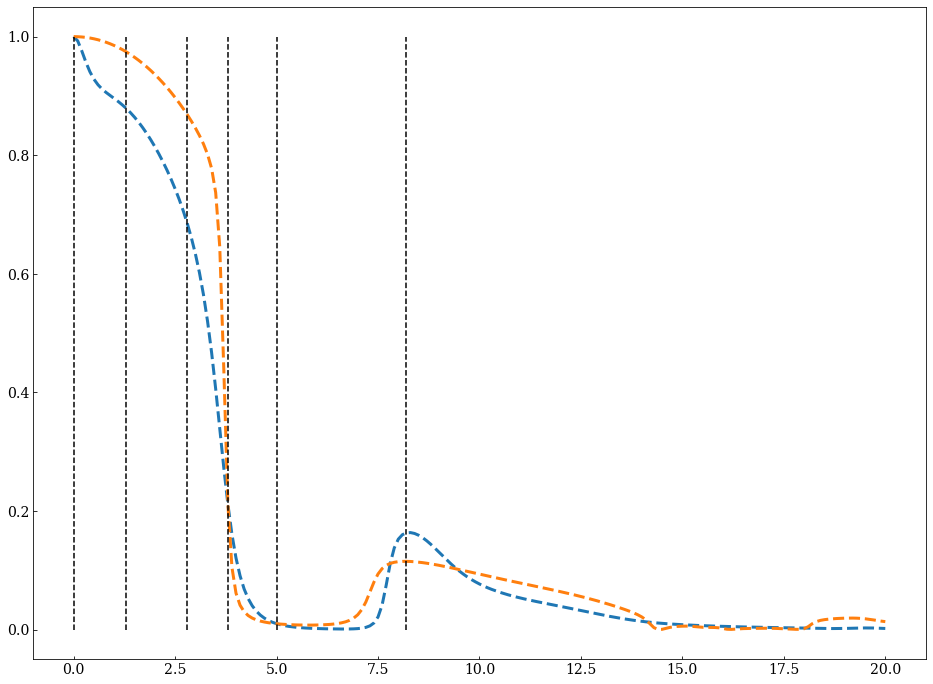

In [6]:
# Calculate overlaps of eigenvectors

inner_products = []
for ele in all_evecs:
    inner_product_V = [np.vdot(pure, unpure) for pure, unpure in zip(pure_evecs, ele)]
    inner_products.append(inner_product_V)

overlaps = [[(x.conj() * x).real for x in ele] for ele in inner_products]

fig, ax = plt.subplots(figsize= (16,12))
dim = len(grid_scaled)

for j in group:
    ys = [overlaps[i][j] for i in range(len(V_scales))]
        
    ax.plot(V_scales, ys, linestyle= '--', linewidth= 3)

select_Vs = [0, 1.3, 2.8, 3.8, 5, 8.2]

for v in select_Vs:
    ax.vlines(x= v, ymin= 0, ymax= 1, linestyles= '--', color= 'k', linewidth= 1.5)

plt.show()

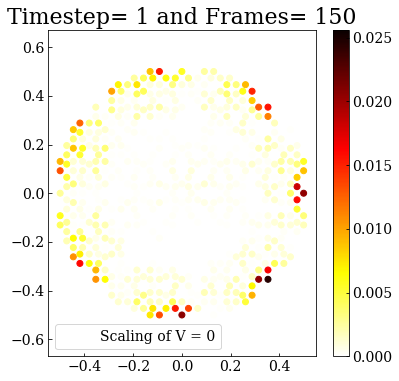

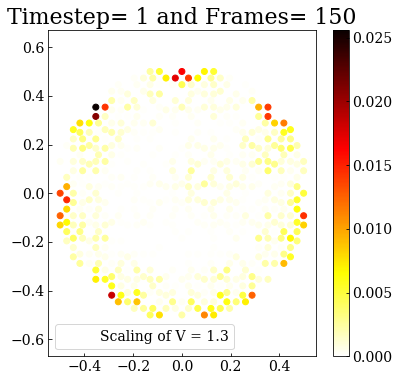

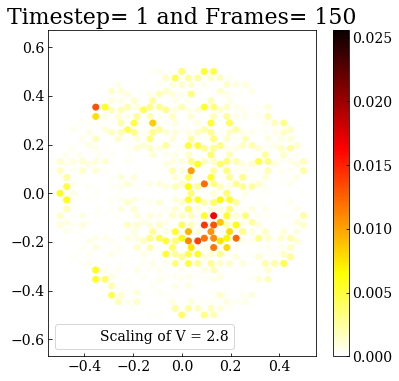

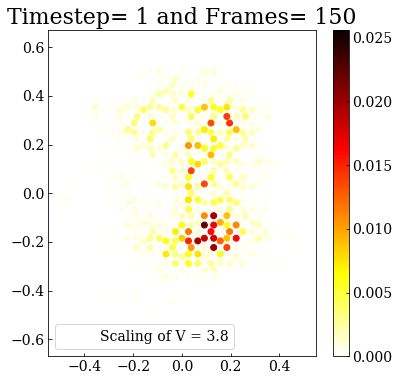

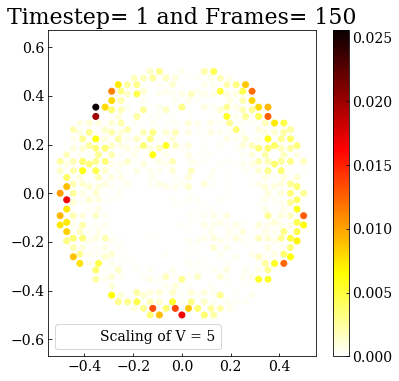

In [7]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

all_vals_select = [Hamil_solve_perturb_positive(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in select_Vs]

all_evals_select = [x for x,y in all_vals_select]
all_evecs_select = [y for x,y in all_vals_select]

pure_evals_select = all_evals_select[0]
pure_evecs_select = all_evecs_select[0]

unpure_evals_select = all_evals_select[1:]
unpure_evecs_select = all_evecs_select[1:]

for vs, evecs, evals in zip(select_Vs, unpure_evecs_select, unpure_evals_select):
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))
    # Set bascis
    sites = ax.scatter(x=[], y=[], c=[])

    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]


    # Set timesteps, state of choice for animation, and number of frames
    timestep = 1
    n_frames = 150
    coefs = [1,1]

    psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)

    dos_max = max(dos_0)

    plt.set_cmap('hot_r')

    # This function will do the animating
    def update(i):
        plt.clf()
        # t is the steps we progress, timestep sets the steplength
        t = i * timestep

        # Using the time evolution to find density of states for each increment
        psi, dos = time_evolve_evec(group, coefs, t, evecs, evals)
        cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
        plt.plot([],[], linestyle= '', label= f'Scaling of V = {vs}')
        plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
        plt.legend(loc= 3)
        plt.colorbar(cf)
        plt.axis('equal')


    anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

    anim.save(f'Animations/V_{vs}_edge.gif', writer='imagemagick', fps=24)

    #anim

In [8]:
"""## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(6,6))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_scaled]
ys = [w[1] for w in grid_scaled]


# Set timesteps, state of choice for animation, and number of frames
timestep = 1
n_frames = 600
B_scale = 0.25

psi_0, dos_0 = time_evolve_evec(group, 0, pure_evecs, pure_evals)

dos_max = (1/5)*max(dos_0)

plt.set_cmap('hot_r')

# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    psi, dos = time_evolve_evec(group, t, pure_evecs, pure_evals)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.plot([],[], linestyle= '', label= f'V = 0')
    plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
    plt.legend(loc= 3)
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

anim.save(f'Pure/edge.gif', writer='imagemagick', fps=30)

#anim"""

"## Magic line for animation\n%matplotlib inline\n# Attempt at animating time evolution\n\n# Set figure up first\nfig, ax = plt.subplots(figsize=(6,6))\n# Set bascis\nsites = ax.scatter(x=[], y=[], c=[])\n\nxs = [w[0] for w in grid_scaled]\nys = [w[1] for w in grid_scaled]\n\n\n# Set timesteps, state of choice for animation, and number of frames\ntimestep = 1\nn_frames = 600\nB_scale = 0.25\n\npsi_0, dos_0 = time_evolve_evec(group, 0, pure_evecs, pure_evals)\n\ndos_max = (1/5)*max(dos_0)\n\nplt.set_cmap('hot_r')\n\n# This function will do the animating\ndef update(i):\n    plt.clf()\n    # t is the steps we progress, timestep sets the steplength\n    t = i * timestep\n\n    # Using the time evolution to find density of states for each increment\n    psi, dos = time_evolve_evec(group, t, pure_evecs, pure_evals)\n    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)\n    plt.plot([],[], linestyle= '', label= f'V = 0')\n    plt.title(f'Timestep= {timestep} and Frames= {n_frame